# Предсказание популярности постов на Главной Aftershock.news

**Цель исследования** -- определить факторы, которые влияют на популярность постов на сайте Aftershok.news.

Можно ли по внешним признакам (время публикации, характеристики автора и заголовка) определить, вызовет ли пост интерес у читателей?

Для ответа на вопрос использованы тексты, опубликованные на главной странице сайта с января 2016 по август 2017 года, и модель RandomForest.

## Загрузка библиотек

In [10]:
# Библиотеки Python
import pandas as pd
from sklearn import cross_validation, grid_search, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import os
import sys
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Модель (Случайный лес)

In [67]:
# Загрузка данных
os.chdir("../data/")
df = pd.read_csv("ashok_features.csv", quotechar = "'")

# Разделение на классы
df['Classes'] = 'Обычный пост'
df['Classes'][df.iloc[:,9] < df.describe().iloc[4, 5]] = 'Непопулярный пост'
df['Classes'][df.iloc[:,9] > df.describe().iloc[6, 5]] = 'Популярный пост'

# Удаление "обычного поста"
df = df[df.Classes != 'Обычный пост']

In [68]:
# Описание данных
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7498 entries, 0 to 14993
Data columns (total 15 columns):
heads       7498 non-null object
length      7498 non-null int64
date        7498 non-null object
month       7498 non-null object
week        7498 non-null object
days        7498 non-null int64
hours       7498 non-null int64
counts      7498 non-null int64
comments    7498 non-null int64
indexes     7498 non-null float64
writers     7498 non-null object
age         7498 non-null int64
country     7498 non-null object
urls        7498 non-null int64
Classes     7498 non-null object
dtypes: float64(1), int64(7), object(7)
memory usage: 937.2+ KB


,heads,length,date,month,week,days,hours,counts,comments,indexes,writers,age,country,urls,Classes
0,Сюрприз! Переворот в Турции - прежнее руководс...,66,2016-07-15,Июль,Friday,15,23,143763,933,14993.5,damadiluma,5,Нидерланды,418309,Популярный пост
1,Санкт-Петербург: Взрыв в метро; 14 погибших и ...,86,2017-04-03,Апрель,Monday,3,14,143178,749,14990.5,Gringoire,1,Россия,505310,Популярный пост
2,Следственный комитет: Пойман Улюкаев за прива...,85,2016-11-15,Ноябрь,Tuesday,15,3,103302,656,14987.0,issima,1,Россия,455848,Популярный пост
3,"Катастрофа с самолетом возле Сочи, на борту бы...",84,2016-12-25,Декабрь,Sunday,25,8,79514,640,14983.0,EugenP,2,Россия,470653,Популярный пост
4,"Франция: Мощный теракт в Ницце, убито 84 отдых...",70,2016-07-15,Июль,Friday,15,0,103836,560,14981.0,alexsword,5,Россия,418058,Популярный пост


In [70]:
# Удаление лишних колонок
df = df.drop(['heads', 'date', 'counts', 'comments', 'indexes', 'urls'], 1)

# Перевод в факторы и кодировка
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

# Разделение на тренировочный и тестовый датасет
train, test = train_test_split(df, test_size = 0.3)
classes = train.pop('Classes').values
testClasses = test.pop('Classes').values

In [80]:
# Создание модели
model = RandomForestClassifier()
model.get_params().keys()

# Создание сетки с параметрами
parameters_grid = {
    'max_depth' : [20, 30, 40, 50, 100, 150],
    'n_estimators' : [300, 400, 500, 600, 800, 1000],
}

# Стратегия кроссвалидации
cv = cross_validation.StratifiedShuffleSplit(classes, n_iter = 3, test_size = 0.3)

# Стратегия поиска по сетке
grid_cv = grid_search.GridSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Тренировка модели
grid_cv.fit(train, classes)

# Характеристики лучшей модели
grid_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
# Предсказание и метрики
predict_labels = grid_cv.predict(test)
print(metrics.classification_report(testClasses, predict_labels))

             precision    recall  f1-score   support

          0       0.66      0.67      0.67      1125
          1       0.67      0.66      0.66      1125

avg / total       0.67      0.67      0.67      2250



## Информативность признаков

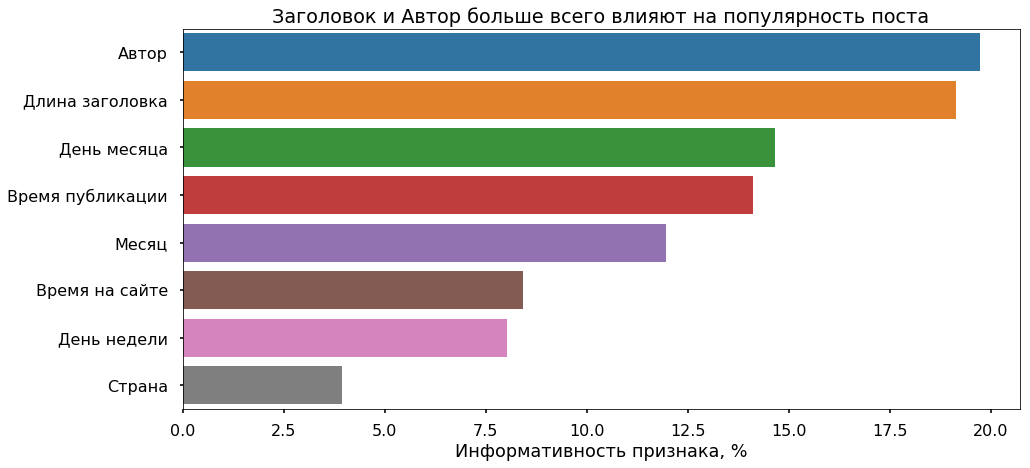

In [106]:
# Информативность признаков
df_plot = pd.DataFrame({'features': ['length', 'month', 'week', 'days', 'hours', 'writers', 'age', 'country'],
                       'importances': grid_cv.best_estimator_.feature_importances_})
df_plot['importances'] = df_plot['importances']*100
df_plot['importances'] = round(df_plot['importances'], 2)
df_plot['features'] = df_plot['features'].astype('category')
df_plot['features'].cat.categories = ["Время на сайте", "Страна", "День месяца", "Время публикации", 
                                      "Длина заголовка", "Месяц", "День недели", "Автор"]
df_plot = df_plot.sort_values(['importances'], ascending = False)
df_plot['features'] = df_plot['features'].astype('str')

# График
plt.figure(figsize=[15, 7])
sns.barplot(x='importances', y='features', data=df_plot)
plt.title('Заголовок и Автор больше всего влияют на популярность поста')
plt.xlabel('Информативность признака, %')
plt.ylabel('')
plt.show()
fig.savefig('../images/Заголовок и Автор больше всего влияют на популярность поста.svg')

## Топ-10 авторов

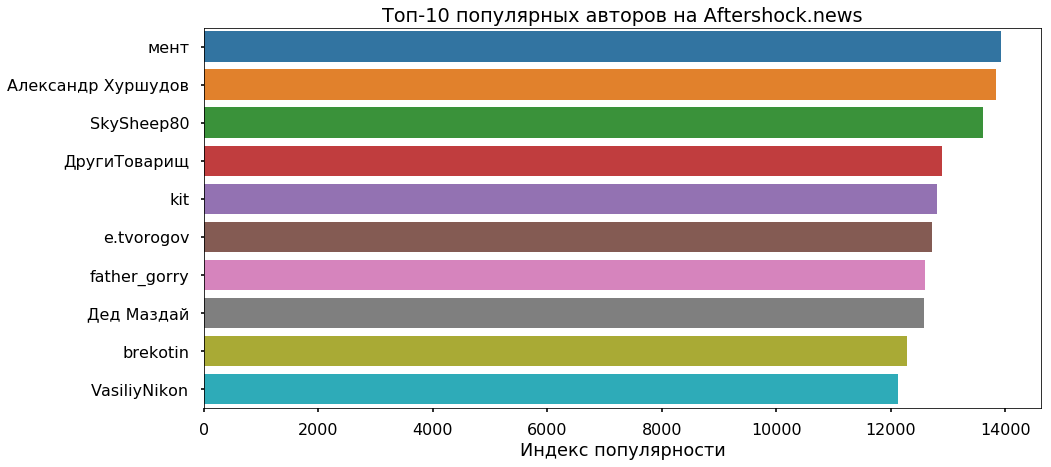

In [105]:
# Загрузка данных
os.chdir("../data/")
df = pd.read_csv("ashok_features.csv", quotechar = "'")

# Сабсет с авторами
df_writers = df[['writers', 'comments', 'counts', 'indexes']]

# более 4 постов - 365, 31% от всех
index = df_writers.writers.value_counts()[df_writers.writers.value_counts() > 5].index.tolist()
df_writers = df_writers.loc[df_writers['writers'].isin(index)]
df_writers = df_writers.groupby(['writers'])
df_writers = df_writers[['counts', 'comments', 'indexes']].median().sort_values(['indexes'], 
                                                                                ascending = False).reset_index()

# График
plt.figure(figsize=(15, 7))
sns.barplot(x='indexes', y='writers', data=df_writers.head(10))
plt.title('Топ-10 популярных авторов на Aftershock.news')
plt.ylabel(' ')
plt.xlabel('Индекс популярности')
plt.show()

## Длина заголовков

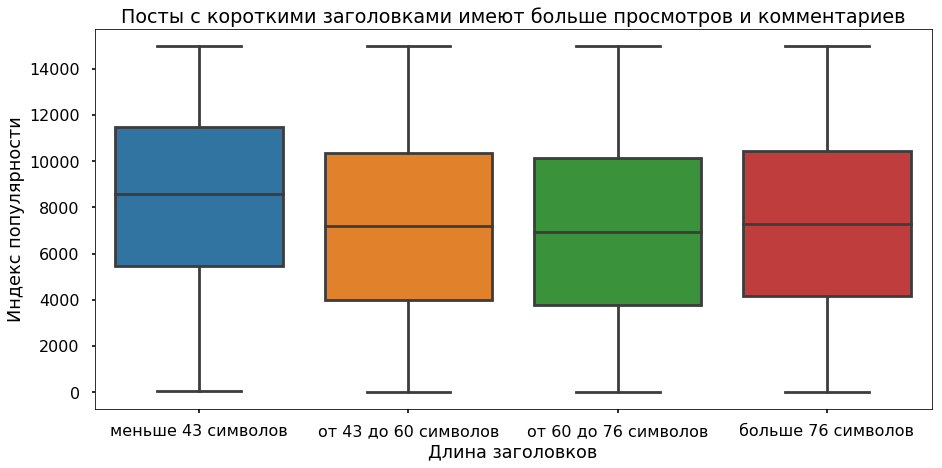

In [109]:
# Добавление квантилей
df_len = df[['length', 'indexes']]
df_len['quant'] = 'Q'
df_len.loc[df_len['length'] <= df_len.length.describe()[4], 'quant'] = 'меньше 43 символов'
df_len.loc[(df_len['length'] > df_len.length.describe()[4]) & 
           (df_len['length'] <= df_len.length.describe()[5]), 'quant'] = 'от 43 до 60 символов'
df_len.loc[(df_len['length'] > df_len.length.describe()[5]) & 
           (df_len['length'] < df_len.length.describe()[6]), 'quant'] = 'от 60 до 76 символов'
df_len.loc[df_len['length'] >= df_len.length.describe()[6], 'quant'] = 'больше 76 символов'
df_len_describe = df_len.length.describe() # Описательная статистика колонки length
df_len.quant = df_len.quant.astype('category')

# Plot
plt.figure(figsize=[15, 7])
sns.boxplot(x='quant', y='indexes', order=['меньше 43 символов', 
                                         'от 43 до 60 символов', 
                                         'от 60 до 76 символов',
                                         'больше 76 символов'], data=df_len)
plt.title('Посты с короткими заголовками имеют больше просмотров и комментариев')
plt.ylabel('Индекс популярности')
plt.xlabel('Длина заголовков')
plt.show()

## Динамика количества просмотров и комментариев

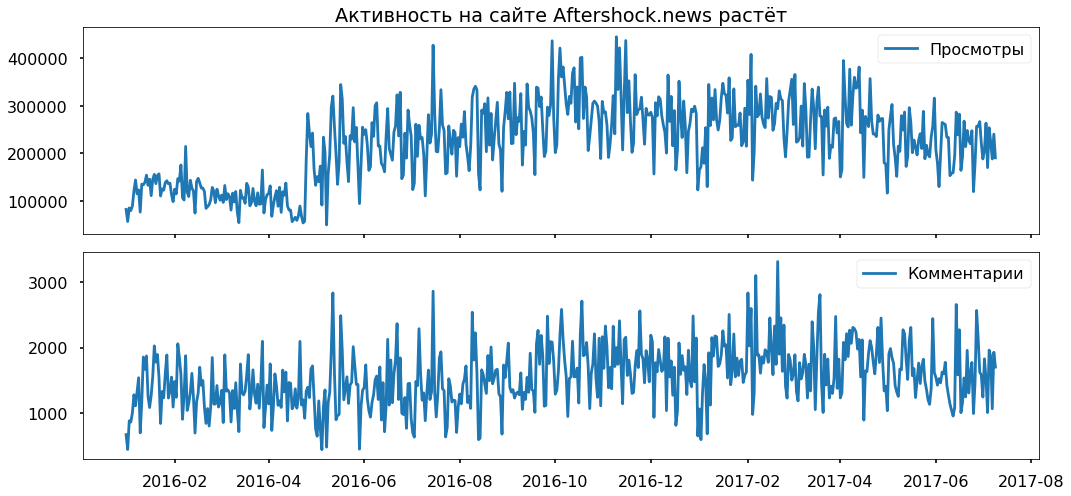

In [110]:
# Подсчёт количества комментариев и просмотров
df_posts = df.groupby(['date'])
df_posts = df_posts[['counts', 'comments']].sum().unstack().reset_index()
df_posts.columns = ['key', 'date', 'value']
df_posts.date = pd.to_datetime(df_posts['date'])
df_posts['key'] = df_posts['key'].astype('category')
df_posts['key'].cat.categories = ["Комментарии", "Просмотры"]
df_posts['key'] = df_posts['key'].astype('str')
df_posts = df_posts[(df_posts['date'] >= '2016-01-01') & (df_posts['date'] < '2017-07-10')]
df_posts.index = df_posts.date

# Plot
plt.figure(figsize=[15, 7])

plt.subplot(211)
plt.plot(df_posts.value[df_posts.key == 'Просмотры'], '-', label='Просмотры')
plt.tick_params(labelbottom='off')
plt.title('Активность на сайте Aftershock.news растёт')
plt.legend()

plt.subplot(212)
plt.plot(df_posts.value[df_posts.key == 'Комментарии'], '-', label='Комментарии')
plt.legend()

plt.tight_layout()
plt.show()

## День месяца

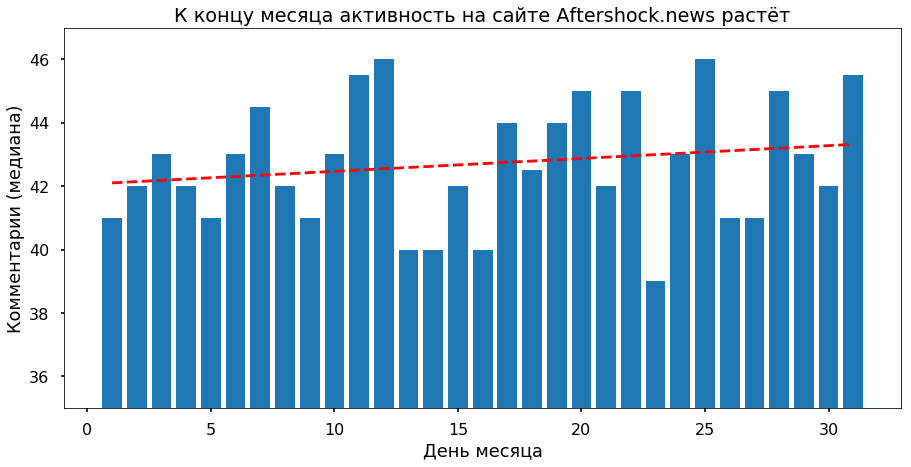

In [111]:
# Сабсет со временем суток
df_days = df[['days', 'comments', 'counts']]

# Подсчёт среднего по дням
df_days = df_days.groupby(['days'])
df_days = df_days[['counts', 'comments']].median().reset_index()
df_days = df_days.sort_values(['days'])

# Преобразование датасета
df_days.index = df_days.days
df_days = df_days[['counts', 'comments']].stack().reset_index()
df_days.columns = ['days', 'key', 'value']
df_days.key = df_days.key.astype('category')
df_days['key'].cat.categories = ["Комментарии", "Просмотры"]
df_days.key = df_days.key.astype('str')

# Plot
plt.figure(figsize=(15, 7))
plt.bar(df_days.days[df_days.key == 'Комментарии'].tolist(), 
        df_days.value[df_days.key == 'Комментарии'].tolist())
z = np.polyfit(df_days.days[df_days.key == 'Комментарии'].tolist(), 
                  df_days.value[df_days.key == 'Комментарии'].tolist(), 1)
p = np.poly1d(z)
plt.plot(df_days.days[df_days.key == 'Комментарии'].tolist(),
         p(df_days.days[df_days.key == 'Комментарии'].tolist()),"r--")
plt.ylim(35, 47)
plt.title("К концу месяца активность на сайте Aftershock.news растёт")
plt.xlabel('День месяца')
plt.ylabel('Комментарии (медиана)')
plt.show()

## Время публикации

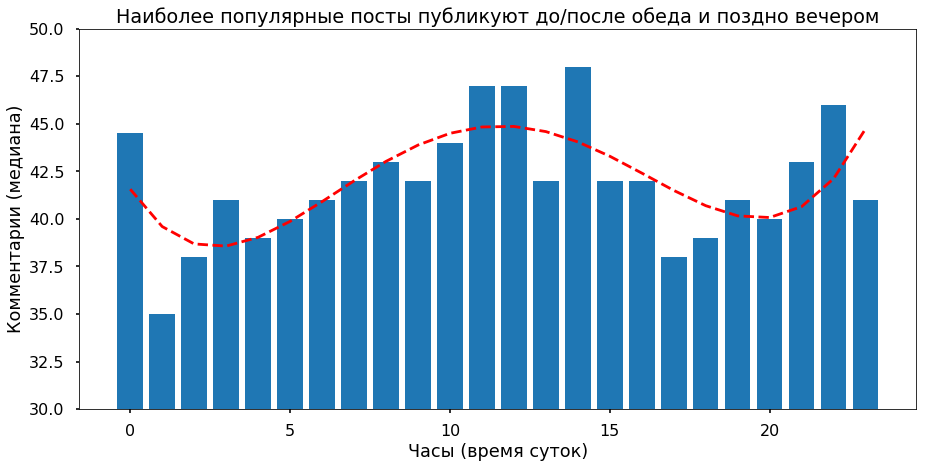

In [112]:
# Сабсет со временем суток
df_hours = df[['hours', 'comments', 'counts']]

# Подсчёт среднего по дням
df_hours = df_hours.groupby(['hours'])
df_hours = df_hours[['counts', 'comments']].median().reset_index()
df_hours = df_hours.sort_values(['hours'])

# Преобразование датасета
df_hours.index = df_hours.hours
df_hours = df_hours[['counts', 'comments']].stack().reset_index()
df_hours.columns = ['hours', 'key', 'value']
df_hours.key = df_hours.key.astype('category')
df_hours['key'].cat.categories = ["Комментарии", "Просмотры"]
df_hours.key = df_hours.key.astype('str')

# Plot
plt.figure(figsize=(15, 7))
plt.bar(df_hours.hours[df_hours.key == 'Комментарии'].tolist(), 
        df_hours.value[df_hours.key == 'Комментарии'].tolist())
z = np.polyfit(df_hours.hours[df_hours.key == 'Комментарии'].tolist(), 
                  df_hours.value[df_hours.key == 'Комментарии'].tolist(), 4)
p = np.poly1d(z)
plt.plot(df_hours.hours[df_hours.key == 'Комментарии'].tolist(),
         p(df_hours.hours[df_hours.key == 'Комментарии'].tolist()),"r--")
plt.ylim(30, 50)
plt.title("Наиболее популярные посты публикуют до/после обеда и поздно вечером")
plt.xlabel('Часы (время суток)')
plt.ylabel('Комментарии (медиана)')
plt.show()

## Месяц

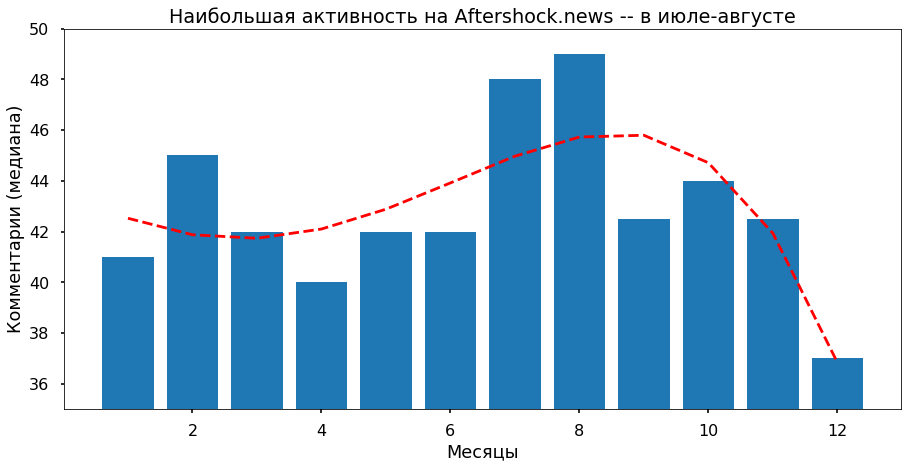

In [113]:
# Сабсет со временем суток
df_month = df[['date', 'comments']]
df_month.date = pd.to_datetime(df_month.date)
df_month['month'] = df_month.date.dt.month
df_month.index = df_month.pop('date')
df_month = df_month.groupby(['month'])
df_month = df_month.comments.median().reset_index()

# Plot
plt.figure(figsize=(15, 7))
plt.bar(df_month.month.tolist(), df_month.comments.tolist())
z = np.polyfit(df_month.month.tolist(), df_month.comments.tolist(), 4)
p = np.poly1d(z)
plt.plot(df_month.month.tolist(), p(df_month.month.tolist()),"r--")
plt.ylim(35, 50)
plt.title("Наибольшая активность на Aftershock.news -- в июле-августе")
plt.xlabel('Месяцы')
plt.ylabel('Комментарии (медиана)')
plt.show()

## День недели

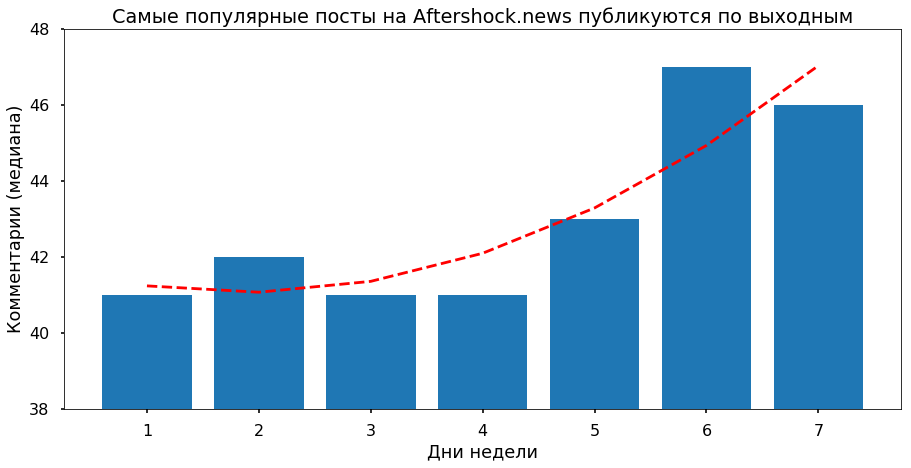

In [114]:
# Сабсет со временем суток
df_week = df[['date', 'comments']]
df_week.date = pd.to_datetime(df_week.date)
df_week['week'] = df_week.date.dt.weekday_name
df_week.index = df_week.pop('date')
df_week = df_week.groupby(['week'])
df_week = df_week.comments.median().reset_index()
df_week.index = df_week.pop('week')
df_week['week'] = [5, 1, 6, 7, 4, 2, 3]
df_week = df_week.sort_values('week')

# Plot
plt.figure(figsize=(15, 7))
plt.bar(df_week.week.tolist(), df_week.comments.tolist())
z = np.polyfit(df_week.week.tolist(), df_week.comments.tolist(), 2)
p = np.poly1d(z)
plt.plot(df_week.week.tolist(), p(df_week.week.tolist()),"r--")
plt.ylim(38, 48)
plt.title("Самые популярные посты на Aftershock.news публикуются по выходным")
plt.xlabel('Дни недели')
plt.ylabel('Комментарии (медиана)')
plt.show()

## Время на сайте

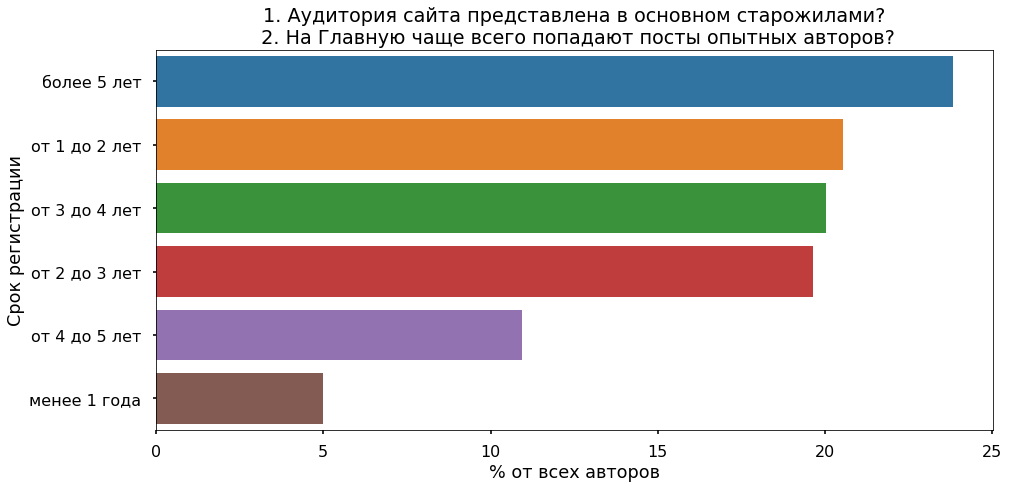

In [126]:
# Время на сайте
df_age = df.age.value_counts().reset_index()
df_age['percent'] = df_age.age/df_age.age.sum()
df_age.percent = round(df_age.percent*100, 2)
df_age['index'] = ["более 5 лет", "от 1 до 2 лет", "от 3 до 4 лет", "от 2 до 3 лет",  "от 4 до 5 лет", "менее 1 года"]

# Plot
plt.figure(figsize=(15, 7))
sns.barplot(x='percent', y='index', data=df_age)
plt.title('1. Аудитория сайта представлена в основном старожилами?\n 2. На Главную чаще всего попадают посты опытных авторов?')
plt.ylabel('Срок регистрации')
plt.yticks()
plt.xlabel('% от всех авторов')
plt.show()

## Страна

85% авторов из России, второе место -- Нидерланды (3%), третье -- Украина (2%).

In [122]:
# Время на сайте
df_country = df.country.value_counts().reset_index()
df_country['percent'] = df_country.country/df_country.country.sum()
df_country.percent = round(df_country.percent*100, 2)
df_country = df_country.iloc[:, [0,2]]
df_country.columns = ['Страна', '% всех пользователей']
df_country.head(10)

,Страна,% всех пользователей
0,Россия,85.35
1,Нидерланды,2.75
2,Украина,2.03
3,Неизвестно,1.86
4,Соединённые Штаты Америки,1.38
5,Франция,1.00
6,Латвия,0.86
7,Белоруссия,0.76
8,Германия,0.65
9,Чешская республика,0.56


# Выводы

1. Aftershock.news всё ещё пользуется популярностью у аудитории -- активность медленно, но растёт;

2. У авторского уникального материала выше шансы привлечь внимание читателей, хотя это во многом зависит от самого автора, от качества контента, который он производит. Публикация интересных перепечаток и резонансных новостей также работает: у такой стратегии меньше полезная отдача, но можно взять количеством, так как подобная деятельность на порядок менее трудозатратна, чем создание оригинальных постов;

3. Посты с короткими заголовками более привлекательны для читателей;

4. У материалов, опубликованных в пятницу, субботу и воскресенье, вероятность быть прочитанными и прокоментированными выше;

5. В будние дни лучше публиковаться до обеда, час после обеда или вечером.

6. Для достоверных выводов по сезонной динамике данных недостаточно.

